In [1]:
import numpy as np
import matplotlib.pyplot as plt

from environments.pricing_env import PricingEnvironment
from learners.greedy import Greedy
from learners.ucb import UCB
from learners.normal_gamma_ts import NormalGammaTS

from data_generators.basic_generator import BasicDataGenerator
%matplotlib inline 

In [2]:
data_gen = BasicDataGenerator(filename='src/basic001.json')
prices = data_gen.get_prices()
bids = data_gen.get_bids()
margins = data_gen.get_margins()
conv_rates = data_gen.get_conversion_rates(mode='aggregate')
n_clicks = data_gen.get_daily_clicks(mode='aggregate')
costs_per_click = data_gen.get_costs_per_click(mode='aggregate')
aggr_tau = data_gen.get_future_purchases(mode='aggregate')

print(15*'-','DATA', '-'*15)
print(f'{prices=}')
print(f'{bids=}')
print(f'{margins=}')
print(f'{conv_rates=}')
print(f'{costs_per_click=}')
print(f'{n_clicks=}')
print(f'{aggr_tau=}')

sel_bid = 3
print(f'\nSelected bid: {bids[sel_bid]}({sel_bid})')
print(f'Fixed CPC: {costs_per_click[sel_bid]}')
print(f'Fixed num_clicks: {n_clicks[sel_bid]} -> {np.rint(n_clicks[sel_bid]).astype(int)}')

print('\n',15*'-','SIMULATION PARAMS', '-'*15)
T = 1000
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')

--------------- DATA ---------------
prices=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
bids=[0.03, 0.04, 0.07, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0]
margins=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
conv_rates=array([0.217, 0.214, 0.208, 0.197, 0.183, 0.164, 0.136, 0.125, 0.116,
       0.098])
costs_per_click=array([0.03 , 0.04 , 0.069, 0.097, 0.189, 0.44 , 0.627, 0.799, 1.105,
       1.375])
n_clicks=array([ 30.107,  38.897,  62.152,  81.492, 126.508, 181.541, 196.399,
       202.562, 206.463, 207.274])
aggr_tau=array([2.95, 2.58, 2.21, 1.84, 1.47, 1.1 , 0.91, 0.75, 0.7 , 0.7 ])

Selected bid: 0.1(3)
Fixed CPC: 0.097
Fixed num_clicks: 81.492 -> 81

 --------------- SIMULATION PARAMS ---------------
Time horizon: 1000 days
Num. experiments: 10


In [3]:
rewards_per_experiment = {}
rewards_per_experiment['Greedy'] = []
rewards_per_experiment['UCB'] = []
daily_rewards_per_experiment = {}
daily_rewards_per_experiment['Greedy'] = []
daily_rewards_per_experiment['UCB'] = []

In [4]:
n_arms = len(prices) 
env_params = {
        'n_arms': n_arms,
        'conversion_rates': conv_rates,
        'cost_per_click': costs_per_click[sel_bid],
        'n_clicks': np.rint(n_clicks[sel_bid]).astype(int),
        'margins': margins, 
        'tau': aggr_tau
    }
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    test_instances = [
        ("Greedy", Greedy(n_arms), PricingEnvironment(**env_params)),
        ("UCB", UCB(n_arms), PricingEnvironment(**env_params))
    ]
    
    for t in range(T):
        for name, learner, env in test_instances:
            pulled_arm = learner.pull_arm()
            daily_reward = env.round(pulled_arm)
            for r in daily_reward:
                learner.update(pulled_arm, r)
            learner.update_daily_rewards(np.sum(daily_reward))
            #if t % 10 == 0 and name != 'Greedy':
            #    print(f'[exp#{e}] t: {t}\n{name}\n{pulled_arm=}\n{daily_reward=}')
            #    print(30*'-')
    #print(f'\n{15*"-"}exp#{e}{15*"-"}\n{test_instances[0][1].mu_0=}, \n{test_instances[0][1].estimated_variance=}, \n{test_instances[0][1].n=},')
    #print(f'\n{15*"-"}exp#{e}{15*"-"}\n{test_instances[0][1].alpha=}, \n{test_instances[0][1].beta=}, \n{test_instances[0][1].mu_0=}, \n{test_instances[0][1].estimated_variance=}, \n{test_instances[0][1].n=},')
    for learner_name, learner, _ in test_instances:
        rewards_per_experiment[learner_name].append(learner.collected_rewards)
        daily_rewards_per_experiment[learner_name].append(learner.daily_collected_rewards)

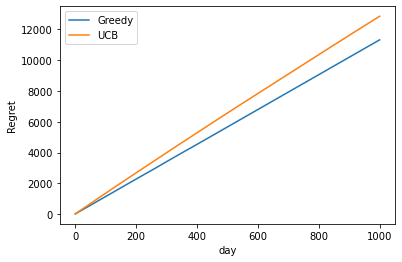

In [6]:
opt_per_round = np.max(test_instances[0][2].get_expected_rewards())
opt_per_day = opt_per_round * env_params['n_clicks']

#opt = [opt_per_day]*T

# Plotting the results
plt.figure()
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(np.cumsum(np.mean(opt_per_day - daily_rewards_per_experiment['Greedy'], axis=0)))
plt.plot(np.cumsum(np.mean(opt_per_day - daily_rewards_per_experiment['UCB'], axis=0)))
plt.legend(["Greedy", "UCB"])

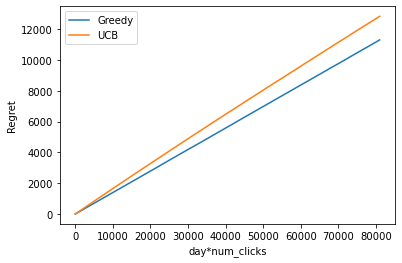

In [7]:
opt_per_round = np.max(test_instances[0][2].get_expected_rewards())
opt_per_day = opt_per_round * env_params['n_clicks']

# Plotting the results
plt.figure()
plt.ylabel("Regret")
plt.xlabel("day*num_clicks")
plt.plot(np.cumsum(np.mean(opt_per_round - rewards_per_experiment['Greedy'], axis=0)))
plt.plot(np.cumsum(np.mean(opt_per_round - rewards_per_experiment['UCB'], axis=0)))
plt.legend(["Greedy", "UCB"])